# PPIDM (84 552 DDIs) - NEW CLASSIFICATION ANALYSIS  
<br>  
<br>  

In [1]:
# import useful libraries
import pandas as pd
from math import *
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
import matplotlib

# ignore the warnings in this notebook
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import ppidm dataframe, output of the p_value python file code
ppidm = pd.read_csv("Input Dataframes/p_value_classified_ppidm_octobre2020.csv", sep="\t")  # shape = (84552, 21)
ppidm

D1       D2     SCORE  INTACT_SCORE              INTACT_PV  \
0      PF03641  PF14793  0.426401      0.000000                    NaN   
1      PF03641  PF10410  0.023700      0.037689  0.0028421486031190435   
2      PF03641  PF03641  0.847512      0.000000                    NaN   
3      PF03641  PF04316  0.029566      0.029566    0.00482704842141971   
4      PF03641  PF03740  0.041030      0.041030  0.0024163521909481302   
...        ...      ...       ...           ...                    ...   
84547  PF02017  PF06991  0.016598      0.016598  0.0009044112182143416   
84548  PF02017  PF09230  0.525765      0.133485  6.492716753332012e-95   
84549  PF02017  PF10240  0.020353      0.000000                    NaN   
84550  PF02017  PF13903  0.020101      0.020101   0.000506502731824795   
84551  PF02017  PF02017  0.721799      0.136364                    0.0   

       DIP_SCORE                 DIP_PV  MINT_SCORE                 MINT_PV  \
0       0.000000                    NaN    0.000000                     NaN   
1       0.353553  0.0002478810572104166    0.000000                     NaN   
2       0.000000                    NaN    0.000000                     NaN   
3       0.000000                    NaN    0.000000                     NaN   
4       0.000000                    NaN    0.000000                     NaN   
...          ...                    ...         ...                     ...   
84547   0.000000                    NaN    0.000000                     NaN   
84548   0.000000                    NaN    0.260133  6.3354327908300134e-27   
84549   0.000000                    NaN    0.000000                     NaN   
84550   0.000000                    NaN    0.000000                     NaN   
84551   0.000000                    NaN    0.368421  6.9075066535066995e-81   

       HPRD_SCORE  ... BIOGRID_SCORE             BIOGRID_PV STRING_EXP_SCORE  \
0        0.000000  ...      0.000000                    NaN         0.000000   
1        0.000000  ...      0.000000                    NaN         0.001488   
2        0.000000  ...      0.000000                    NaN         0.000358   
3        0.000000  ...      0.000000                    NaN         0.000000   
4        0.000000  ...      0.000000                    NaN         0.000000   
...           ...  ...           ...                    ...              ...   
84547    0.000000  ...      0.000000                    NaN         0.000000   
84548    0.363803  ...      0.091928  2.001768708760625e-66         0.011765   
84549    0.000000  ...      0.020353   0.003707515357056853         0.000000   
84550    0.000000  ...      0.000000                    NaN         0.000000   
84551    0.352941  ...      0.112676                    0.0         0.011315   

                STRING_EXP_PV STRING_REST_SCORE        STRING_REST_PV  \
0                         NaN          0.000000                   NaN   
1      0.00010343806622056505          0.001493  0.000122557065470192   
2                         0.0          0.000360                   0.0   
3                         NaN          0.000000                   NaN   
4                         NaN          0.000000                   NaN   
...                       ...               ...                   ...   
84547                     NaN          0.000000                   NaN   
84548                     0.0          0.012209                   0.0   
84549                     NaN          0.000000                   NaN   
84550                     NaN          0.000000                   NaN   
84551                     0.0          0.011615                   0.0   

      SIFTS_SCORE       SIFTS_PV   CLASS INTERPRO  
0        0.426401   2.077646e-55  Silver      Yes  
1        0.000000            NaN  Bronze       No  
2        1.000000  7.370939e-227  Silver      Yes  
3        0.000000            NaN  Bronze       No  
4        0.000000            NaN  Bronze       No  
...           ...       

<br>  
## Add Goldstandard column to classified PPIDM:

In this section we add to ppidm a column `IN_GOLDSTANDARD` in which we specify whether the DDI is in the goldstandard or not.   
We get **6989** DDIs that are in both PPIDM and the GoldStandard.

In [3]:
# import goldstandard
GS = pd.read_pickle("Input Dataframes/positives_goldstandard_classified")
GS_ddis = list( GS['DDI'].apply(set) )

# import ppidm
ppidm = pd.read_csv("Input Dataframes/p_value_classified_ppidm_octobre2020.csv", sep="\t")  # (84552, 21)

# add the yes/no in GoldStandard column to ppidm
ppidm['DDI'] = ppidm[['D1','D2']].apply(frozenset, axis=1)
ppidm['IN_GOLDSTANDARD'] = ppidm.iloc[:,21].apply(lambda x: 'yes' if x in GS_ddis else 'no')  # ~50 seconds
ppidm.drop(labels='DDI', axis=1, inplace=True)


In [4]:
# counting of unique values of the 'IN_GOLDSTANDARD' column
ppidm.IN_GOLDSTANDARD.value_counts()

no     77563
yes     6989
Name: IN_GOLDSTANDARD, dtype: int64

<br>  
## Scores & P-values : Numerical values cleaning:

The numerical values in ppidm dataframe will be modified as the following:
    - The scores will be rounded to 8 decimals;
    - The p_values equal to '1*' will become equal to '1', and the floats will be rounded to 3 decimals. Note that the '1*' has been assigned to 7 950 p_values. A '1*' means that the real p_value is actually greater than 1.

In [5]:
# define a list of indexes of p_values and scores columns
p_value_columns=[i*2 for i in range(2,10)]
scores_columns = [2]+[(i*2)+1 for i in range(1,9)]

# define a variable 'count' which computes the number of p_values equal to 1*
count=0

# define functions of rounding to apply to scores and p_values
def round_p_value(x):
    global count
    if x=='1*': 
        count+=1
        return '1'
    if not isnan(float(x)):
        if float(x)==0: return 0
        return "{0:.3e}".format(float(x))
    else: return x
    
def round_scores(x):
    if float(x)==0 : return 0
    return f"{float(x):.8f}"

# rounding of p_values
for i in p_value_columns: ppidm.iloc[:,i] =pd.DataFrame(ppidm.iloc[:,i]).applymap(round_p_value)
    
# rounding of scores
for i in scores_columns:  ppidm.iloc[:,i] =pd.DataFrame(ppidm.iloc[:,i]).applymap(round_scores)

In [6]:
print(" The number of '1*' p_values is: ", count,".")

 The number of '1*' p_values is:  7950 .


In [7]:
# display the updated PPIDM dataframe
ppidm

D1       D2       SCORE INTACT_SCORE  INTACT_PV   DIP_SCORE  \
0      PF03641  PF14793  0.42640143            0        NaN           0   
1      PF03641  PF10410  0.02370042   0.03768892  2.842e-03  0.35355339   
2      PF03641  PF03641  0.84751232            0        NaN           0   
3      PF03641  PF04316  0.02956562   0.02956562  4.827e-03           0   
4      PF03641  PF03740  0.04103050   0.04103050  2.416e-03           0   
...        ...      ...         ...          ...        ...         ...   
84547  PF02017  PF06991  0.01659765   0.01659765  9.044e-04           0   
84548  PF02017  PF09230  0.52576450   0.13348476  6.493e-95           0   
84549  PF02017  PF10240  0.02035314            0        NaN           0   
84550  PF02017  PF13903  0.02010076   0.02010076  5.065e-04           0   
84551  PF02017  PF02017  0.72179860   0.13636364          0           0   

          DIP_PV  MINT_SCORE    MINT_PV  HPRD_SCORE  ... BIOGRID_PV  \
0            NaN           0        NaN           0  ...        NaN   
1      2.479e-04           0        NaN           0  ...        NaN   
2            NaN           0        NaN           0  ...        NaN   
3            NaN           0        NaN           0  ...        NaN   
4            NaN           0        NaN           0  ...        NaN   
...          ...         ...        ...         ...  ...        ...   
84547        NaN           0        NaN           0  ...        NaN   
84548        NaN  0.26013299  6.335e-27  0.36380344  ...  2.002e-66   
84549        NaN           0        NaN           0  ...  3.708e-03   
84550        NaN           0        NaN           0  ...        NaN   
84551        NaN  0.36842105  6.908e-81  0.35294118  ...          0   

      STRING_EXP_SCORE STRING_EXP_PV STRING_REST_SCORE STRING_REST_PV  \
0                    0           NaN                 0            NaN   
1           0.00148769     1.034e-04        0.00149332      1.226e-04   
2           0.00035791             0        0.00035971              0   
3                    0           NaN                 0            NaN   
4                    0           NaN                 0            NaN   
...                ...           ...               ...            ...   
84547                0           NaN                 0            NaN   
84548       0.01176504             0        0.01220872              0   
84549                0           NaN                 0            NaN   
84550                0           NaN                 0            NaN   
84551       0.01131466             0        0.01161504              0   

      SIFTS_SCORE    SIFTS_PV   CLASS INTERPRO IN_GOLDSTANDARD  
0      0.42640143   2.078e-55  Silver      Yes             yes  
1               0         NaN  Bronze       No              no  
2      1.00000000  7.371e-227  Silver      Yes             yes  
3               0         NaN  Bronze       No              no  
4               0         NaN  Bronze       No              no  
...           ...         ...     ...      ...             ...  
84547           0         NaN  Bronze       No              no  
84548  0.70710678   3.088e-10    Gold       No              no  
84549           0         NaN  Bronze       No              no  
84550           0         NaN  Bronze       No              no  
84551  1.00000000   3.629e-53    Gold      Yes             yes  

[84552 rows x 22 columns]

In [8]:
# save the results:
#ppidm.to_csv('p_value_classified_ppidm_gs_column.csv', index = False)
#ppidm.to_pickle("p_value_classified_ppidm_gs_column")

<br>  
## Classes subsets & PPIDM sorting:

When counting the number of DDIs in each class we find:  
- Gold: 9175 DDIs.
- Silver: 24934 DDIs.
- Bronze: 50443 DDIs.  
$\Rightarrow$ Sum = 84552 DDIs.  

In [9]:
# sort ppidm by the scores column, in a descending order
score_sort = ppidm.sort_values([ 'SCORE'], axis=0, ascending=False)

# split the sorted ppidm dataframes unto subset for each class 
gold = score_sort[ score_sort.CLASS =='Gold']       # shape = (6273, 22)
silver = score_sort[ score_sort.CLASS =='Silver']   # shape = (11549, 22)
bronze = score_sort[ score_sort.CLASS =='Bronze']   # shape = (66730, 22)

# create a sorted PPIDM by the classes then by the scores in a descending order
sorted_ppidm = pd.concat([gold, silver, bronze], axis=0)
sorted_ppidm.SCORE = sorted_ppidm.SCORE.apply(float)

In [10]:

plt.figure(figsize=(12,10))
colors = ['#E5CC00','#D7D7D1','#D18A36']
plot3 = sns.boxplot(x="CLASS", y="SCORE", data=sorted_ppidm, palette=sns.color_palette(colors))
plot3.set_title('Boxplot: PPIDM Classes Scores')

Text(0.5, 1.0, 'Boxplot: PPIDM Classes Scores')

In [11]:
pd.DataFrame(group.describe().rename(columns={'SCORE':name}).squeeze() for name, group in sorted_ppidm.groupby('CLASS')).loc[['Gold', 'Silver', 'Bronze']]

count      mean       std       min       25%       50%       75%  \
Gold     9175.0  0.265327  0.256664  0.015866  0.057893  0.157400  0.409114   
Silver  24934.0  0.193736  0.301505  0.015860  0.022646  0.044583  0.179540   
Bronze  50443.0  0.042856  0.059413  0.015860  0.019672  0.026365  0.042070   

        max  
Gold    1.0  
Silver  1.0  
Bronze  1.0

In [12]:
# saving the resulting dataframes under three formats: python variable(to_pickle), csv and excel files.

#sorted_ppidm.to_pickle("sorted ppidm and classes subests/ppidm_classified_sorted")
#sorted_ppidm.to_csv("sorted ppidm and classes subests/ppidm_classified_sorted.csv", index=False,na_rep="NA")
#sorted_ppidm.to_excel("sorted ppidm and classes subests/ppidm_classified_sorted.xlsx", index=False,na_rep="NA")

#gold.to_pickle("sorted ppidm and classes subests/ppidm_gold_classified_sorted")
#gold.to_csv("sorted ppidm and classes subests/ppidm_gold_classified_sorted.csv", index=False,na_rep="NA")
#gold.to_excel("sorted ppidm and classes subests/ppidm_gold_classified_sorted.xlsx", index=False,na_rep="NA")

#silver.to_pickle("sorted ppidm and classes subests/ppidm_silver_classified_sorted")
#silver.to_csv("sorted ppidm and classes subests/ppidm_silver_classified_sorted.csv", index=False,na_rep="NA")
#silver.to_excel("sorted ppidm and classes subests/ppidm_silver_classified_sorted.xlsx", index=False,na_rep="NA")

#bronze.to_pickle("sorted ppidm and classes subests/ppidm_bronze_classified_sorted")
#bronze.to_csv("sorted ppidm and classes subests/ppidm_bronze_classified_sorted.csv", index=False,na_rep="NA")
#bronze.to_excel("sorted ppidm and classes subests/ppidm_bronze_classified_sorted.xlsx", index=False,na_rep="NA")

<br>  
## Homo-DDIs in PPIDM - Classification counts:

Homo-DDIs are interactions between the same domain. Here we split these DDIs according to their class. The results are:  
- Total number of Homo-DDIs: 7203.
- Gold: 3000 DDIs.
- Silver: 4160 DDIs.
- Bronze: 43 DDIs.


In [13]:
# select the Homo-DDIs from ppidm
ppidm_homo = sorted_ppidm[sorted_ppidm['D1']==sorted_ppidm['D2']]

# split into three subsets according to the class
ppidm_homo_gold = ppidm_homo[ppidm_homo['CLASS']=='Gold']
ppidm_homo_silver = ppidm_homo[ppidm_homo['CLASS']=='Silver']
ppidm_homo_bronze = ppidm_homo[ppidm_homo['CLASS']=='Bronze']

In [14]:
print('Gold:', ppidm_homo_gold.shape[0], 'DDIs.')
print('Silver:', ppidm_homo_silver.shape[0], 'DDIs.')
print('Bronze:',ppidm_homo_bronze.shape[0], 'DDIs.')
print('Sum =',ppidm_homo_gold.shape[0] + ppidm_homo_silver.shape[0] + ppidm_homo_bronze.shape[0], 'DDIs.')

Gold: 3000 DDIs.
Silver: 4160 DDIs.
Bronze: 43 DDIs.
Sum = 7203 DDIs.


Text(0.5, 1.0, 'Boxplot: PPIDM homo-DDIs Classes Scores')

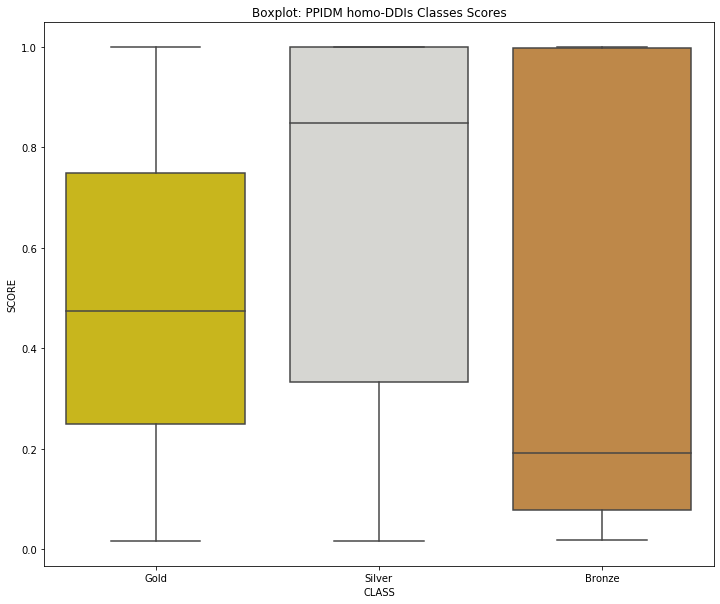

In [15]:
ppidm_homo.SCORE = ppidm_homo.SCORE.apply(float)
plt.figure(figsize=(12,10))
colors = ['#E5CC00','#D7D7D1','#D18A36']
plot3 = sns.boxplot(x="CLASS", y="SCORE", data=ppidm_homo, palette=sns.color_palette(colors))
plot3.set_title('Boxplot: PPIDM homo-DDIs Classes Scores')

In [16]:
pd.DataFrame(group.describe().rename(columns={'SCORE':name}).squeeze() for name, group in ppidm_homo.groupby('CLASS')).loc[['Gold', 'Silver', 'Bronze']]

count      mean       std       min       25%       50%       75%  \
Gold    3000.0  0.480154  0.267886  0.015977  0.249889  0.474005  0.748451   
Silver  4160.0  0.666906  0.373411  0.015863  0.333333  0.848160  1.000000   
Bronze    43.0  0.419891  0.409354  0.017857  0.078334  0.191304  0.997525   

        max  
Gold    1.0  
Silver  1.0  
Bronze  1.0

## PPIDM Pfam Entries:

Here we calculate the total number of pfam entries in PPIDM database. We find **12 098** entries.

In [17]:
len(set(ppidm.D1)|set(ppidm.D2))

12098

<br>  

## PPIDM in New 3DID-2020 Analysis:

$Definition:$  
The new portion of 3did_2020 is the version of 3did database released in 2020 (probably in April) from which omit the DDIs of 3did 2017 (february) release. This latter database is a main constituent of the goldstandard.
The code below generates the intersection database between PPIDM and this new portion of 3did_2020. It contains:
- Total number of DDIs: **800** out of 3854, which means that PPIDM infers 20.758 % of the new DDIs from 3did_2020 ,
- Gold: 258 DDIs.
- Silver: 419 DDIs.
- Bronze: 123 DDIs.

In [18]:
# prepare a simple version of ppidm dataframe, containing a DDI, Domain1, Domain2, score and class columns:
ppidm = pd.read_pickle("sorted ppidm and classes subests/ppidm_classified_sorted")
ddi_set = pd.DataFrame(ppidm[['D1','D2']].apply(frozenset, axis=1))
simple_ppidm = pd.concat([ddi_set, ppidm[['D1', 'D2', 'SCORE', 'CLASS']]], axis=1)
simple_ppidm.columns = ['DDI', 'D1', 'D2', 'SCORE', 'CLASS']

In [19]:
# import 3did, february 2017 and 2020 versions
df_3did_2017_1 = pd.read_pickle("Input Dataframes/dataframe_3did_flat_v1_2017")  # shape = (10593, 4)
df_3did_2020 = pd.read_pickle("Input Dataframes/dataframe_3did_2020")    # shape = (13499, 4)
df_3did_2020 = df_3did_2020[['DDI ppidm', 'DDI', 'Number of PDB entries', 'Liste of Structures']]
df_3did_2020.columns = ['DDI', 'DDI full name', 'Number of PDB structures', 'List of structures']
df_3did_2020.index = [i for i in range(len(df_3did_2020))]

# extracting new released DDI: 3did_2020 \ 3did_2017
origin = df_3did_2017_1[["DDI"]].applymap(frozenset)
df_3did_2020[["DDI"]] = df_3did_2020[["DDI"]].applymap(frozenset)
new_3did_2020 = df_3did_2020.merge(origin,  how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only'].drop(columns=['_merge'])

# create the intersection dataframe between ppidm and the dataframe of new DDIs in 3did_2020
intersection = new_3did_2020.merge(simple_ppidm, on="DDI", how="inner")
nr_3did = new_3did_2020.shape[0]
nr_inter = intersection.shape[0]
print("Number of new DDIs in 3did_2020:", nr_3did, '.')
print("Number of DDIs in the intersection btw PPIDM and the new portion of 3did_2020:", nr_inter,"(",round(100*nr_inter/nr_3did,3),"%) .")


Number of new DDIs in 3did_2020: 3854 .
Number of DDIs in the intersection btw PPIDM and the new portion of 3did_2020: 800 ( 20.758 %) .


In [20]:
# create classes subsets from the intersection of PPIDM and new DDIs in 3did_2020
intersection_gold = intersection[intersection['CLASS']=='Gold']
intersection_silver = intersection[intersection['CLASS']=='Silver']
intersection_bronze = intersection[intersection['CLASS']=='Bronze']

# print the number of DDIs per Class subset
print('Gold:', intersection_gold.shape[0], 'DDIs.')
print('Silver:', intersection_silver.shape[0], 'DDIs.')
print('Bronze:',intersection_bronze.shape[0], 'DDIs.')
print('Sum =',intersection_gold.shape[0] + intersection_silver.shape[0] + intersection_bronze.shape[0], 'DDIs.')

Gold: 258 DDIs.
Silver: 419 DDIs.
Bronze: 123 DDIs.
Sum = 800 DDIs.


In [21]:
intersection2 = pd.concat([intersection_gold, intersection_silver, intersection_bronze])
intersection2.SCORE = intersection2.SCORE.apply(float)
plt.figure(figsize=(12,10))
colors = ['#E5CC00','#D7D7D1','#D18A36']
plot3 = sns.boxplot(x="CLASS", y="SCORE", data=intersection2, palette=sns.color_palette(colors))
plot3.set_title('Boxplot - PPIDM intersection with 3did2020-delta - Classes Scores')

Text(0.5, 1.0, 'Boxplot - PPIDM intersection with 3did2020-delta - Classes Scores')

In [22]:
pd.DataFrame(group.describe().rename(columns={'SCORE':name}).squeeze() for name, group in intersection2.groupby('CLASS')).loc[['Gold', 'Silver', 'Bronze']]

count      mean       std       min       25%       50%       75%  \
Gold    258.0  0.222342  0.228943  0.016016  0.060304  0.135611  0.294573   
Silver  419.0  0.228254  0.308558  0.015881  0.029069  0.076923  0.253400   
Bronze  123.0  0.099549  0.129960  0.015907  0.029711  0.063354  0.112224   

            max  
Gold    0.94752  
Silver  1.00000  
Bronze  1.00000